# Accessing Summit EFD
2021.08.06  
Bruno C. Quint  

## Introduction

Let me use this notebook as a tool to teach myself how to access the Engineering and Facility Database (EFD) at the Summit while trying to do some explanatory data analysis. Again, my primary goal here is to learn the Python interface with to the EFD.

It turns out, that I started to use this notebook for multiple purposes. I am leaving all of them here so people and use it as examples.

## Setup 

Here is where I will import all the libraries used in this notebook. I usually export my code to modules and packages so the notebook is cleaner. However, having all the code here allows quicker reference for myself and others in the future.  

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

from astropy.time import Time

## Helper Functions

One thing that I like to do on my notebooks is to create my own functions and separate them using MarkDown Headers for easy navigation. Here are a few examples.

### retrieve_efd_client()

First of all, the notebook will have different behavior if we run at the Summit or at the NCSA TestSand (NTS) (or other simulated environments). This function simply wraps this difference.

In [3]:
def retrieve_efd_client(is_at_summit=True):
    """
    Retrieves a client to the Engireering Facility Database. 
    
    Parameters
    ----------
    is_at_summit : bool, optional
        If this notebook runs at the Summit, returns a client that connect to 
        the Summit EFD. Otherwhice, results the NCSA TestSand (NST) EFD.
    
    Returns
    -------
    EfdClient : the interface object between Nublado and the Summit or NST EFD.
    """
    from lsst_efd_client import EfdClient
    
    c = EfdClient('summit_efd') if is_at_summit \
        else EfdClient('ncsa_teststand_efd') 
        
    return c


client = retrieve_efd_client()

## Cryo/Cold1/Cold2 Temperatures Vs Rotator Angle

We used these plots during the Rotator Re-Verification. We notices that the Cryo Reject temperature was going up as we moved towards negative rotations. These plots confirm it.

In [4]:
# I need to pass timestamps to the client to get my time series 
# start = Time('2021-10-01T14:00:00', scale='tai', format='isot') 
# end = Time('2021-10-01T16:00:00', scale='tai', format='isot')

# start = Time('2021-10-04T15:00:00', scale='tai', format='isot') 
# end = Time('2021-10-04T17:00:00', scale='tai', format='isot')

start = Time('2021-10-05T13:30:00', scale='tai', format='isot') 
end = Time('2021-10-05T16:00:00', scale='tai', format='isot')

# And here is how I retrieve my data as a Pandas DataFrame
df_rotator = await client.select_time_series(
    'lsst.sal.MTRotator.rotation', 
    fields='actualPosition', 
    start=start, 
    end=end)
df_rotator = df_rotator.resample('1s').mean()

df_cryo_rej_temp = await client.select_time_series(
    'lsst.sal.CCCamera.vacuum_Cryo', 
    fields=['rejectTemperature', 'temperature'], 
    start=start, 
    end=end)
df_cryo_rej_temp = df_cryo_rej_temp.resample('1s').mean()
df_cryo_rej_temp = df_cryo_rej_temp.rename(
    columns={'temperature': 'temp_cryo', 'rejectTemperature': 'rejtemp_cryo'})

df_cold1 = await client.select_time_series(
    'lsst.sal.CCCamera.vacuum_Cold1', 
    fields=['rejectTemperature', 'temperature'], 
    start=start, 
    end=end)
df_cold1 = df_cold1.resample('1s').mean()
df_cold1 = df_cold1.rename(
    columns={'temperature': 'temp_cold1', 'rejectTemperature': 'rejtemp_cold1'})

df_cold2 = await client.select_time_series(
    'lsst.sal.CCCamera.vacuum_Cold2', 
    fields=['rejectTemperature', 'temperature'], 
    start=start, 
    end=end)
df_cold2 = df_cold2.resample('1s').mean()
df_cold2 = df_cold2.rename(
    columns={'temperature': 'temp_cold2', 'rejectTemperature': 'rejtemp_cold2'})

df = pd.merge(df_rotator, df_cryo_rej_temp, left_index=True, right_index=True)
df = pd.merge(df, df_cold1, left_index=True, right_index=True)
df = pd.merge(df, df_cold2, left_index=True, right_index=True)
df = df.dropna()

### Temperatures And Rotator Angle

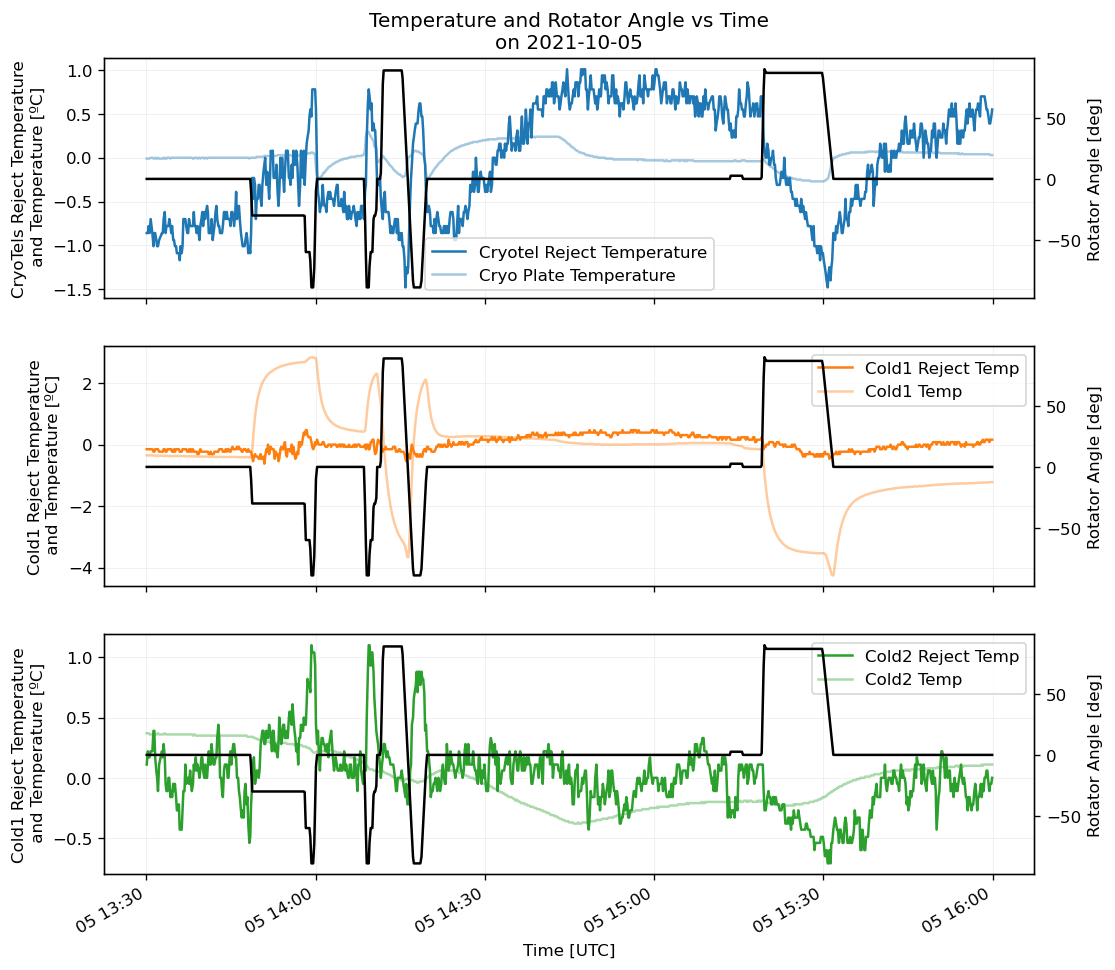

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(
    num="Temperatures and Rotator Angle", 
    dpi=120, figsize=(10, 10), nrows=3, sharex=True)

# Plot Data
ax1.plot(df['rejtemp_cryo'] - df['rejtemp_cryo'].median(), 
         'C0-', label='Cryotel Reject Temperature')
ax1.plot(df['temp_cryo'] - df['temp_cryo'].median(), 
         'C0-', alpha=0.4, label='Cryo Plate Temperature')
ax1.legend()

ax2.plot(df['rejtemp_cold1'] - df['rejtemp_cold1'].median(), 
         'C1-', label='Cold1 Reject Temp')
ax2.plot(df['temp_cold1'] - df['temp_cold1'].median(), 
         'C1-', alpha=0.4, label='Cold1 Temp')
ax2.legend()

ax3.plot(df['rejtemp_cold2'] - df['rejtemp_cold2'].median(), 
         'C2-', label='Cold2 Reject Temp')
ax3.plot(df['temp_cold2'] - df['temp_cold2'].median(), 
         'C2-', alpha=0.4, label='Cold2 Temp')
ax3.legend()

# Display title and sub-title
ax1.set_title(f"Temperature and Rotator Angle vs Time\n"
              f"on {df.index[0]:%Y-%m-%d}")

# Set labels
ax1.set_ylabel("CryoTels Reject Temperature\n and Temperature [ºC]")
ax2.set_ylabel("Cold1 Reject Temperature\n and Temperature [ºC]")
ax3.set_ylabel("Cold1 Reject Temperature\n and Temperature [ºC]") 
ax3.set_xlabel("Time [UTC]")

# Setting grid
for ax in (ax1, ax2, ax3):
    ax.grid(lw='0.5', alpha=0.2, ls='-')

    # Twin X 
    ax2 = ax.twinx()
    ax2.plot(df['actualPosition'], 'k-', label='Rotator Angle')
    ax2.set_ylabel('Rotator Angle [deg]')

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()
fig.savefig('rotang_and_cryorejtemp.png')

# Display Plot
plt.show()

### Temperatures Vs Rotator Angle

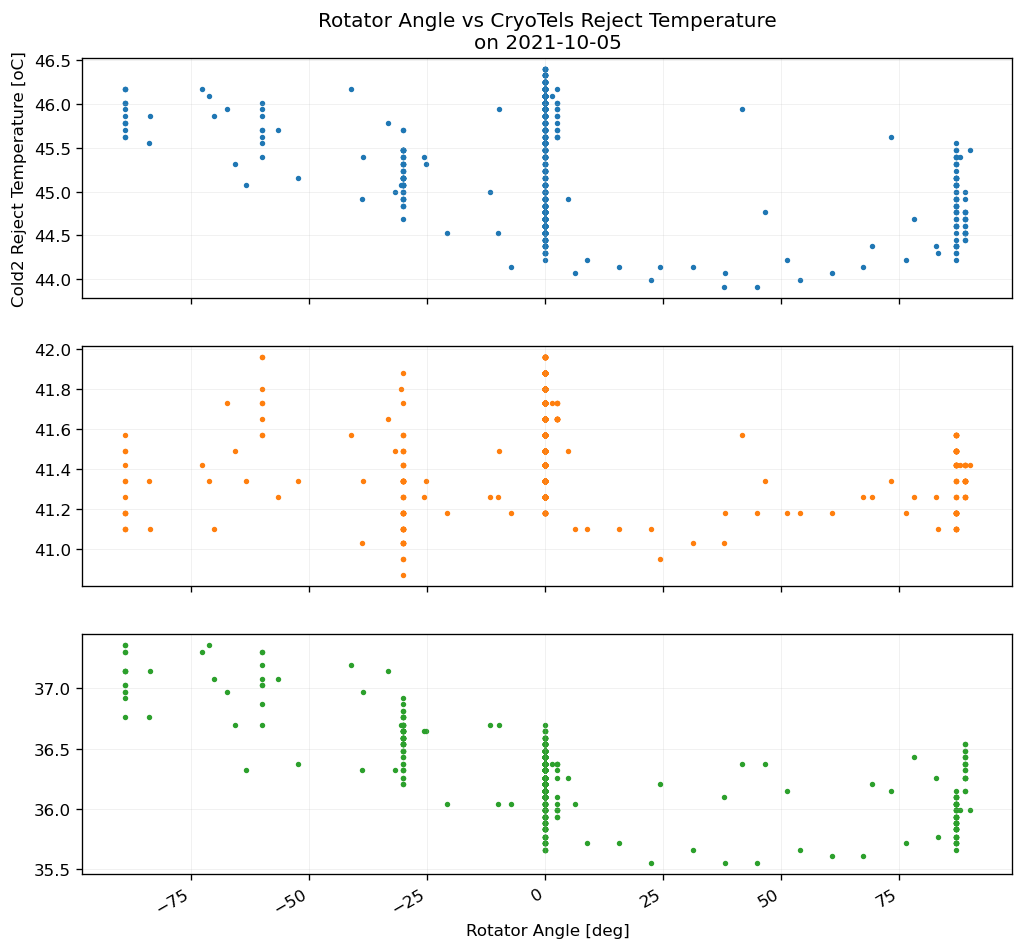

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(
    num="Temperatures Vs Rotator Angle", 
    dpi=120, figsize=(10, 10), nrows=3, sharex=True)

# Plot Data
ax1.scatter(df['actualPosition'], df['rejtemp_cryo'], s=5, c='C0')
ax2.scatter(df['actualPosition'], df['rejtemp_cold1'], s=5, c='C1')
ax3.scatter(df['actualPosition'], df['rejtemp_cold2'], s=5, c='C2')

# Set labels
ax3.set_xlabel("Rotator Angle [deg]")
ax1.set_ylabel("CryoTels Reject Temperature [oC]")
ax1.set_ylabel("Cold1 Reject Temperature [oC]")
ax1.set_ylabel("Cold2 Reject Temperature [oC]")

# Display title and sub-title
ax1.set_title(f"Rotator Angle vs CryoTels Reject Temperature\n"
             f"on {df.index[0]:%Y-%m-%d}")

# Setting grid
for ax in (ax1, ax2, ax3):
    ax.grid(lw='0.5', alpha=0.2, ls='-')

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

fig.savefig('rotang_vs_cryorejtemp.png')

# Display Plot
plt.show()

## Wind Speed

In [24]:
# I need to pass timestamps to the client to get my time series 
start = Time('2021-10-01T14:00:00', scale='tai', format='isot') 
end = Time('2021-10-02T14:00:00', scale='tai', format='isot')

# And here is how I retrieve my data as a Pandas DataFrame
df = await client.select_time_series(
    'lsst.sal.WeatherStation.windSpeed', 
    fields='value', 
    start=start, 
    end=end)

df = df.rename(columns={'value': 'wind_speed'})
df = df.resample('1s').mean()
df = df.dropna()

,wind_speed
2021-10-01 14:00:58+00:00,7.9
2021-10-01 14:01:58+00:00,9.4
2021-10-01 14:02:58+00:00,8.9
2021-10-01 14:03:58+00:00,4.5
2021-10-01 14:04:58+00:00,10.2
...,...
2021-10-02 13:55:58+00:00,6.2
2021-10-02 13:56:58+00:00,4.3
2021-10-02 13:57:58+00:00,2.4
2021-10-02 13:58:58+00:00,4.2


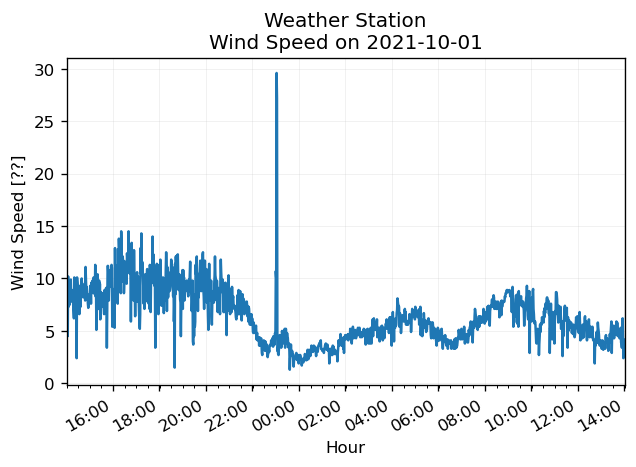

In [25]:
fig, ax = plt.subplots(num="Weather Station - Wind Speed", dpi=120)

# Major ticks every 5 Hour.
loc_maj_ticks = mdates.HourLocator(interval=2)
ax.xaxis.set_major_locator(loc_maj_ticks)

# Minor ticks every 0.5 Hour
loc_min_ticks = mdates.MinuteLocator(interval=30)
ax.xaxis.set_minor_locator(loc_min_ticks)

# Format Major 
fmt = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(fmt)

# Set labels
ax.set_xlabel("Hour")
ax.set_ylabel("Wind Speed [??]")

# Round to nearest years.
datemin = df.index[0].round('min')
datemax = df.index[-1].round('min') + np.timedelta64(1, 'm')
ax.set_xlim(datemin, datemax)

# Plot Data
ax.plot(df.index, df['wind_speed'])

# Display title and sub-title
ax.set_title(f"Weather Station\nWind Speed on {df.index[0]:%Y-%m-%d}")

# Setting grid
ax.grid(lw='0.5', alpha=0.2, ls='-')

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

# Display Plot
plt.show()